# Laptop Price Prediction

### Import Needed Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

### Take A Peak To The Data

In [2]:
data = pd.read_csv("data.csv")
data.head()

,Unnamed: 0.1,Unnamed: 0,brand,name,price,spec_rating,processor,CPU,Ram,Ram_type,ROM,ROM_type,GPU,display_size,resolution_width,resolution_height,OS,warranty
0,0,0,HP,Victus 15-fb0157AX Gaming Laptop,49900,73.000000,5th Gen AMD Ryzen 5 5600H,"Hexa Core, 12 Threads",8GB,DDR4,512GB,SSD,4GB AMD Radeon RX 6500M,15.6,1920,1080,Windows 11 OS,1
1,1,1,HP,15s-fq5007TU Laptop,39900,60.000000,12th Gen Intel Core i3 1215U,"Hexa Core (2P + 4E), 8 Threads",8GB,DDR4,512GB,SSD,Intel UHD Graphics,15.6,1920,1080,Windows 11 OS,1
2,2,2,Acer,One 14 Z8-415 Laptop,26990,69.323529,11th Gen Intel Core i3 1115G4,"Dual Core, 4 Threads",8GB,DDR4,512GB,SSD,Intel Iris Xe Graphics,14.0,1920,1080,Windows 11 OS,1
3,3,3,Lenovo,Yoga Slim 6 14IAP8 82WU0095IN Laptop,59729,66.000000,12th Gen Intel Core i5 1240P,"12 Cores (4P + 8E), 16 Threads",16GB,LPDDR5,512GB,SSD,Intel Integrated Iris Xe,14.0,2240,1400,Windows 11 OS,1
4,4,4,Apple,MacBook Air 2020 MGND3HN Laptop,69990,69.323529,Apple M1,Octa Core (4P + 4E),8GB,DDR4,256GB,SSD,Apple M1 Integrated Graphics,13.3,2560,1600,Mac OS,1


In [3]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'brand', 'name', 'price', 'spec_rating',
       'processor', 'CPU', 'Ram', 'Ram_type', 'ROM', 'ROM_type', 'GPU',
       'display_size', 'resolution_width', 'resolution_height', 'OS',
       'warranty'],
      dtype='object')

In [4]:
data.shape

(893, 18)

In [5]:
# Drop the Unnamed: 0.1 & Unnamed: 0 becasue they are not useful in the analysis
data = data.drop(['Unnamed: 0.1','Unnamed: 0'], axis = 1)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              893 non-null    object 
 1   name               893 non-null    object 
 2   price              893 non-null    int64  
 3   spec_rating        893 non-null    float64
 4   processor          893 non-null    object 
 5   CPU                893 non-null    object 
 6   Ram                893 non-null    object 
 7   Ram_type           893 non-null    object 
 8   ROM                893 non-null    object 
 9   ROM_type           893 non-null    object 
 10  GPU                893 non-null    object 
 11  display_size       893 non-null    float64
 12  resolution_width   893 non-null    int64  
 13  resolution_height  893 non-null    int64  
 14  OS                 893 non-null    object 
 15  warranty           893 non-null    int64  
dtypes: float64(2), int64(4), o

### Handle Name & Ram & ROM & OS Attributes

In [7]:
# Split name to type & model col
# Function to determine laptop type
def get_laptop_type(laptop_name):
    if 'Gaming' in laptop_name:
        return 'Gaming Laptop'
    else:
        return 'Laptop'

# Add the Gaming Laptop / Laptop to the type col
data['type'] = data['name'].apply(get_laptop_type)

# Remove the type from the name to get the model
data['model'] = data['name'].str.replace('Gaming Laptop', '').str.replace('Laptop', '')

# Drop the name col
data = data.drop(['name'], axis= 1)

In [8]:
# Remove GB from Ram
data['Ram'] = data['Ram'].str.replace('GB', '')
# Convert the column to numeric type
data['Ram'] = pd.to_numeric(data['Ram'])

In [9]:
# Remove GB from ROM & if found TB convert it to GB
def convert_to_gb(value):
    if 'TB' in value:
        # If the value is in TB, remove 'TB', convert the number part to GB
        return int(value.replace('TB', '')) * 1000
    else:
        # If the value is in GB, just remove 'GB'
        return int(value.replace('GB', ''))

data['ROM'] = data['ROM'].apply(convert_to_gb)

In [10]:
#Remove spaces from OS
def remove_spaces(string):
    return string.replace(' ', '')

data['OS'] = data['OS'].apply(remove_spaces)

In [11]:
display(data['OS'].unique())

array(['Windows11OS', 'MacOS', 'Android11OS', 'DOSOS', 'Windows10OS',
       'ChromeOS', 'WindowsOS', 'UbuntuOS', 'MacCatalinaOS', 'DOS3.0OS',
       'MacHighSierraOS', 'Mac10.15.3\tOS'], dtype=object)

In [12]:
data.head()

,brand,price,spec_rating,processor,CPU,Ram,Ram_type,ROM,ROM_type,GPU,display_size,resolution_width,resolution_height,OS,warranty,type,model
0,HP,49900,73.000000,5th Gen AMD Ryzen 5 5600H,"Hexa Core, 12 Threads",8,DDR4,512,SSD,4GB AMD Radeon RX 6500M,15.6,1920,1080,Windows11OS,1,Gaming Laptop,Victus 15-fb0157AX
1,HP,39900,60.000000,12th Gen Intel Core i3 1215U,"Hexa Core (2P + 4E), 8 Threads",8,DDR4,512,SSD,Intel UHD Graphics,15.6,1920,1080,Windows11OS,1,Laptop,15s-fq5007TU
2,Acer,26990,69.323529,11th Gen Intel Core i3 1115G4,"Dual Core, 4 Threads",8,DDR4,512,SSD,Intel Iris Xe Graphics,14.0,1920,1080,Windows11OS,1,Laptop,One 14 Z8-415
3,Lenovo,59729,66.000000,12th Gen Intel Core i5 1240P,"12 Cores (4P + 8E), 16 Threads",16,LPDDR5,512,SSD,Intel Integrated Iris Xe,14.0,2240,1400,Windows11OS,1,Laptop,Yoga Slim 6 14IAP8 82WU0095IN
4,Apple,69990,69.323529,Apple M1,Octa Core (4P + 4E),8,DDR4,256,SSD,Apple M1 Integrated Graphics,13.3,2560,1600,MacOS,1,Laptop,MacBook Air 2020 MGND3HN


### Handle CPU Attribute

In [13]:
display(data["CPU"].unique())

array(['Hexa Core, 12 Threads', 'Hexa Core (2P + 4E), 8 Threads',
       'Dual Core, 4 Threads', '12 Cores (4P + 8E), 16 Threads',
       'Octa Core (4P + 4E)', 'Octa Core (4P + 4E), 12 Threads',
       '10 Cores (2P + 8E), 12 Threads', 'Dual Core, 2 Threads',
       'Octa Core', 'Quad Core, 8 Threads',
       '14 Cores (6P + 8E), 20 Threads', 'Octa Core, 16 Threads',
       'Octa Core, 8 Threads', '24 Cores (8P + 16E), 32 Threads',
       '10 Cores (6P + 4E), 16 Threads', '14 Cores, 20 Threads',
       'Quad Core, 4 Threads', 'Quad Core',
       '5 Cores (1P + 4E), 6 Threads', '16 Cores (8P + 8E), 24 Threads',
       '16 Cores, 32 Threads', '14 Cores (6P + 8E)', '12 Cores',
       '10 Cores, 12 Threads', 'Octa Core, 12 Threads',
       '10 Cores (8P + 2E)', '10 Cores', '24 Cores (8P + 16E)',
       '20 Threads'], dtype=object)

In [14]:
# split CPU to core & thread col
def split_cpu(cpu_val):
    if ',' in cpu_val:
        parts = cpu_val.split(',')
        # Check the number of parts
        if len(parts) == 2:
        #If there are two parts, assign them to variables
            part1 = parts[0].strip()
            part2 = parts[1].strip()
        else:
            # If there is only one part, assign it to part1 and set part2 as None
            part1 = parts[0].strip()
            part2 = None
    else:
        if 'cores' in cpu_val.lower() or 'core' in cpu_val.lower():
            part1 = cpu_val
            part2 = None

        else:
            part1 = None
            part2 = cpu_val
    return part1,part2


data['core'] ,data['thread'] = zip(*data['CPU'].apply(split_cpu))

# Remove thread from thread
data['thread'] = data['thread'].str.replace('Threads', '')
# Convert the column to numeric type
data['thread'] = pd.to_numeric(data['thread'])


# Drop the CPU col
data = data.drop(['CPU'], axis= 1)

In [15]:
data['core'].isnull().sum()

1

In [16]:
data['thread'].isnull().sum()

26

In [17]:
#fill nulls in thread col
imputer = KNNImputer(n_neighbors=3, metric='nan_euclidean')

# Reshape your data using DataFrame method
data_reshaped = data['thread'].values.reshape(-1,1)

# Perform the imputation
data_imputed = imputer.fit_transform(data_reshaped)
data_imputed = data_imputed.astype(int)

# Assign the imputed data back to the 'thread' column
data['thread'] = data_imputed


In [18]:
# Fill nulls in the core col
m_price = data['price'].median()
closest_price_row = data.iloc[(data['price'] - m_price).abs().idxmin()]
data['core'] = data['core'].fillna(closest_price_row['core'])

### Handle Processor & GPU Attributes

### Check If ALL The NULLs Are Filled

In [20]:
# Check Nulls
for c in data.columns:
  display(data[c].isnull().sum())

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

In [21]:
data.head()

,brand,price,spec_rating,Ram,Ram_type,ROM,ROM_type,display_size,resolution_width,resolution_height,...,type,model,core,thread,prc_Brand,prc_Generation,prc_CoreType,GPU_Brand,GPU_VRAM,GPU_Type
0,HP,49900,73.000000,8,DDR4,512,SSD,15.6,1920,1080,...,Gaming Laptop,Victus 15-fb0157AX,Hexa Core,12,other,other,other,other,other,Radeon RX 6500M
1,HP,39900,60.000000,8,DDR4,512,SSD,15.6,1920,1080,...,Laptop,15s-fq5007TU,Hexa Core (2P + 4E),8,other,other,other,other,other,UHD Graphics
2,Acer,26990,69.323529,8,DDR4,512,SSD,14.0,1920,1080,...,Laptop,One 14 Z8-415,Dual Core,4,other,other,other,other,other,Iris Xe Graphics
3,Lenovo,59729,66.000000,16,LPDDR5,512,SSD,14.0,2240,1400,...,Laptop,Yoga Slim 6 14IAP8 82WU0095IN,12 Cores (4P + 8E),16,other,other,other,other,other,Integrated Iris Xe
4,Apple,69990,69.323529,8,DDR4,256,SSD,13.3,2560,1600,...,Laptop,MacBook Air 2020 MGND3HN,Octa Core (4P + 4E),12,other,other,M1,other,other,other


### Encoding

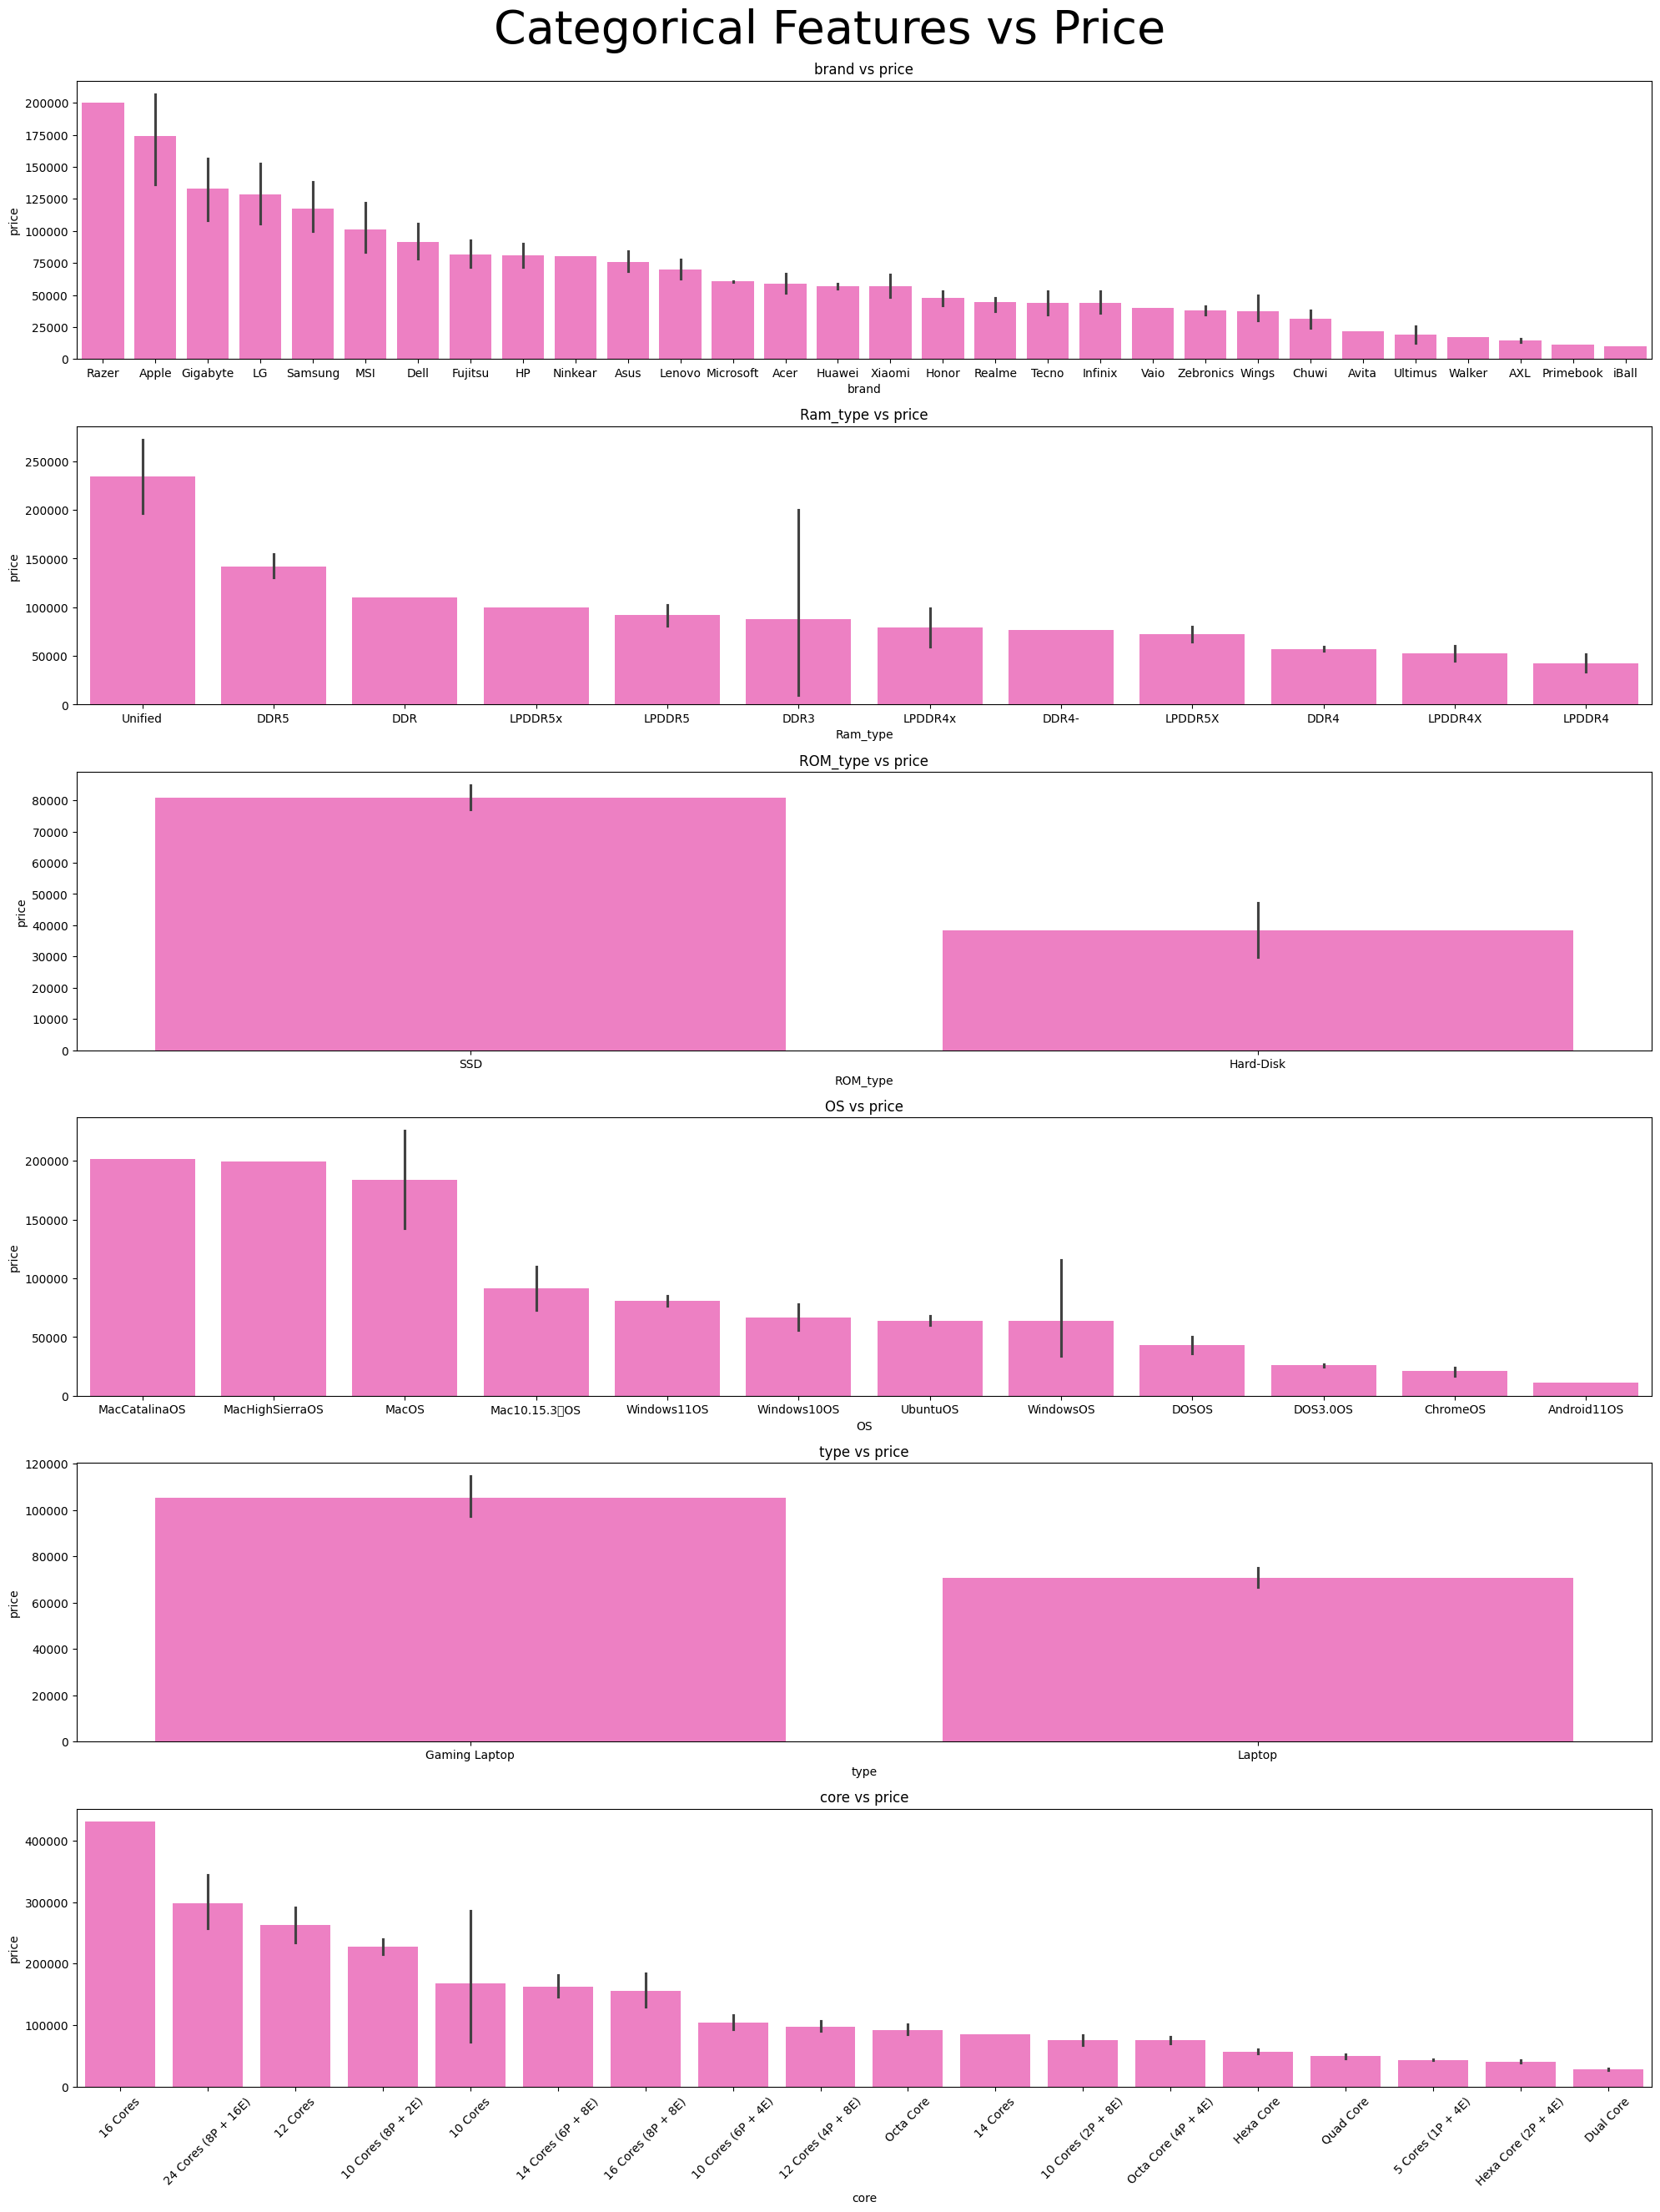

In [22]:
def print_bar_graph(df):
    filtered_cols = df.columns[df.dtypes == 'object']
    filtered_cols = filtered_cols[~filtered_cols.isin(['prc_Brand', 'prc_Generation','prc_CoreType', 'GPU_Brand','GPU_VRAM', 'GPU_Type',  'model'])]
    num_plots = len(filtered_cols)

    fig, axs = plt.subplots(num_plots, 1, layout="constrained", figsize=(20, 25))

    for i, c in enumerate(filtered_cols):
        order = df.groupby(c)['price'].mean().sort_values(ascending=False).index
        sns.barplot(x=df[c], y='price', data=df, ax=axs[i], color='#FF6EC7', order = order)
        axs[i].set_title('{} vs price'.format(c))

    # To ensure the subplots do not overlap
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.suptitle('Categorical Features vs Price', x=0.5, y=1.02, fontsize =40)

    plt.show()

print_bar_graph(data)

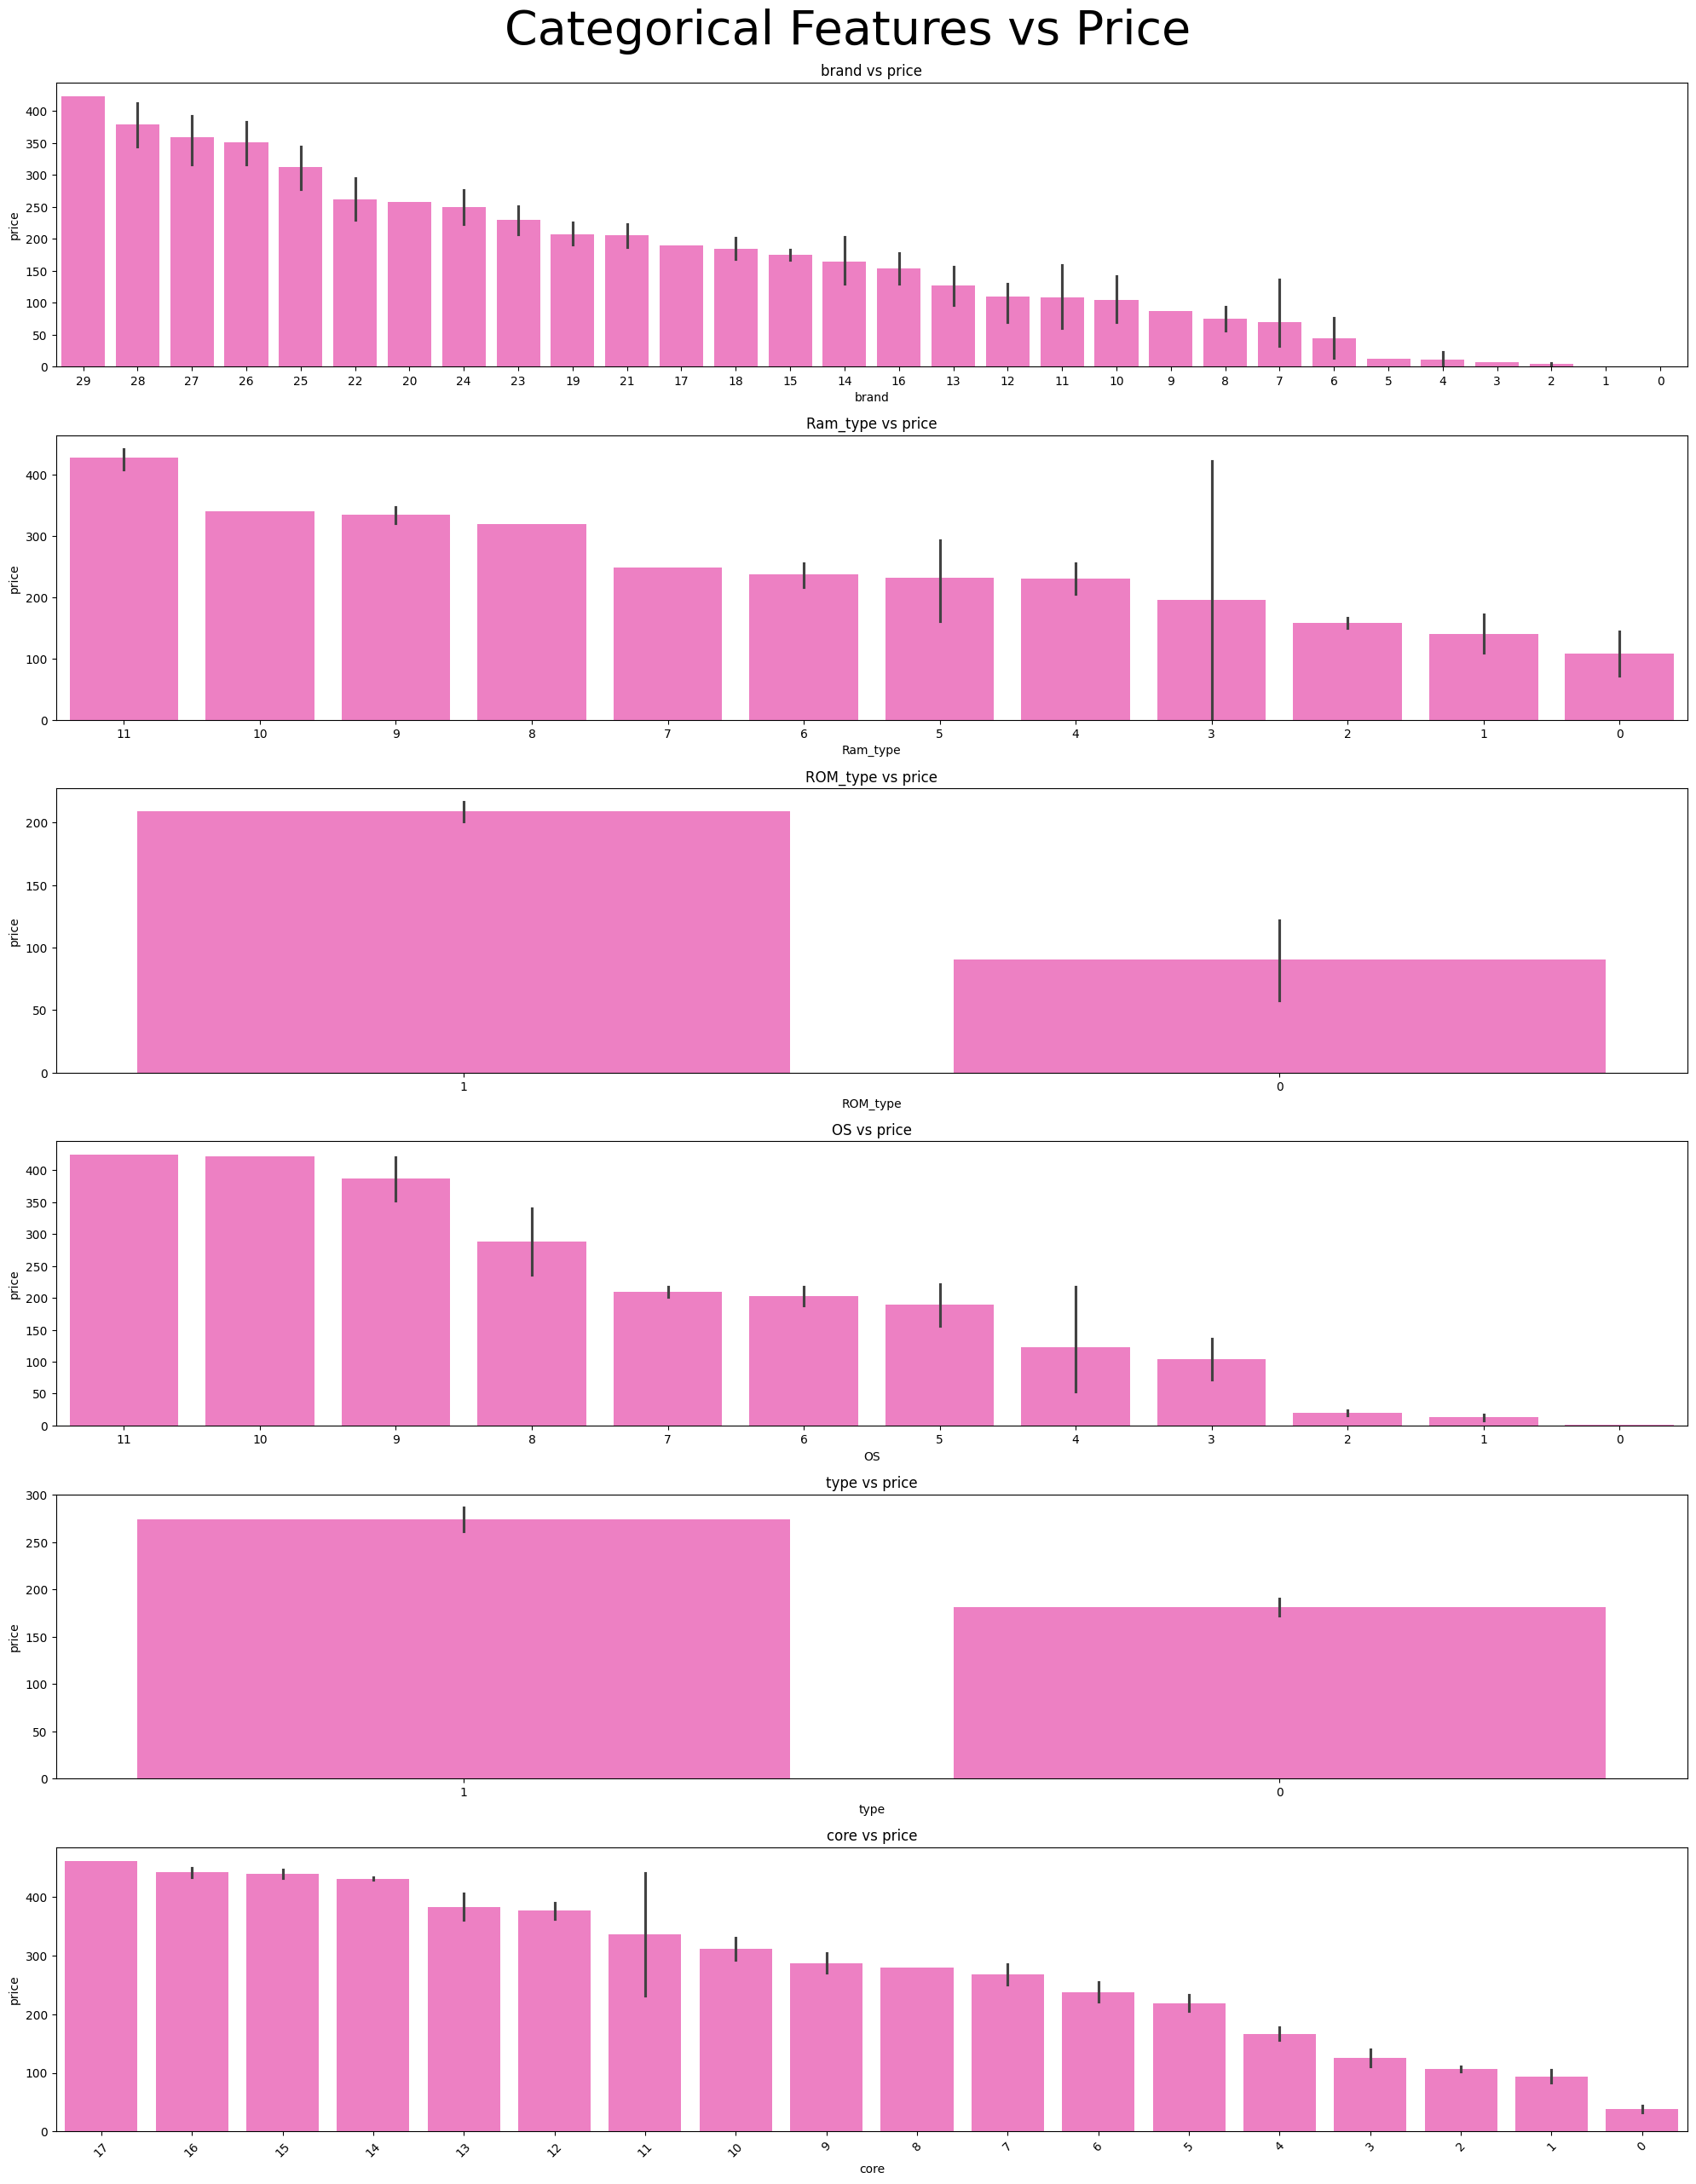

In [23]:
# Encode categorical attributes except ['GPU']
def label_encode_categories(df):
    for col in data.columns:
        value_counts = df.groupby(col)['price'].mean()
        value_counts = value_counts.sort_values(ascending=True)
        label_encoder = {cat: i for i, cat in enumerate(value_counts.index)}
        df.loc[:, col] = df[col].replace(label_encoder).astype(int)

    return df

data = label_encode_categories(data.copy())

print_bar_graph(data)

In [24]:
# Convert the encoded columns into int type
for c in data.columns:
  if data[c].dtype == 'object':
    data[c]= data[c].astype(int)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893 entries, 0 to 892
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              893 non-null    int32  
 1   price              893 non-null    int64  
 2   spec_rating        893 non-null    float64
 3   Ram                893 non-null    int64  
 4   Ram_type           893 non-null    int32  
 5   ROM                893 non-null    int64  
 6   ROM_type           893 non-null    int32  
 7   display_size       893 non-null    float64
 8   resolution_width   893 non-null    int64  
 9   resolution_height  893 non-null    int64  
 10  OS                 893 non-null    int32  
 11  warranty           893 non-null    int64  
 12  type               893 non-null    int32  
 13  model              893 non-null    int32  
 14  core               893 non-null    int32  
 15  thread             893 non-null    int32  
 16  prc_Brand          893 non

In [26]:
data.head()

,brand,price,spec_rating,Ram,Ram_type,ROM,ROM_type,display_size,resolution_width,resolution_height,...,type,model,core,thread,prc_Brand,prc_Generation,prc_CoreType,GPU_Brand,GPU_VRAM,GPU_Type
0,21,135,14.0,3,2,4,1,4.0,5,3,...,1,246,4,4,1,0,0,0,0,24
1,21,85,1.0,3,2,4,1,4.0,5,3,...,0,158,1,3,1,0,0,0,0,17
2,16,24,0.0,3,2,4,1,5.0,5,3,...,0,37,0,1,1,0,0,0,0,58
3,18,185,8.0,4,6,4,1,5.0,8,4,...,0,374,9,5,1,0,0,0,0,49
4,28,226,0.0,3,2,3,1,7.0,12,15,...,0,479,6,4,1,0,1,0,0,73


### Transformation & Checking Outliers

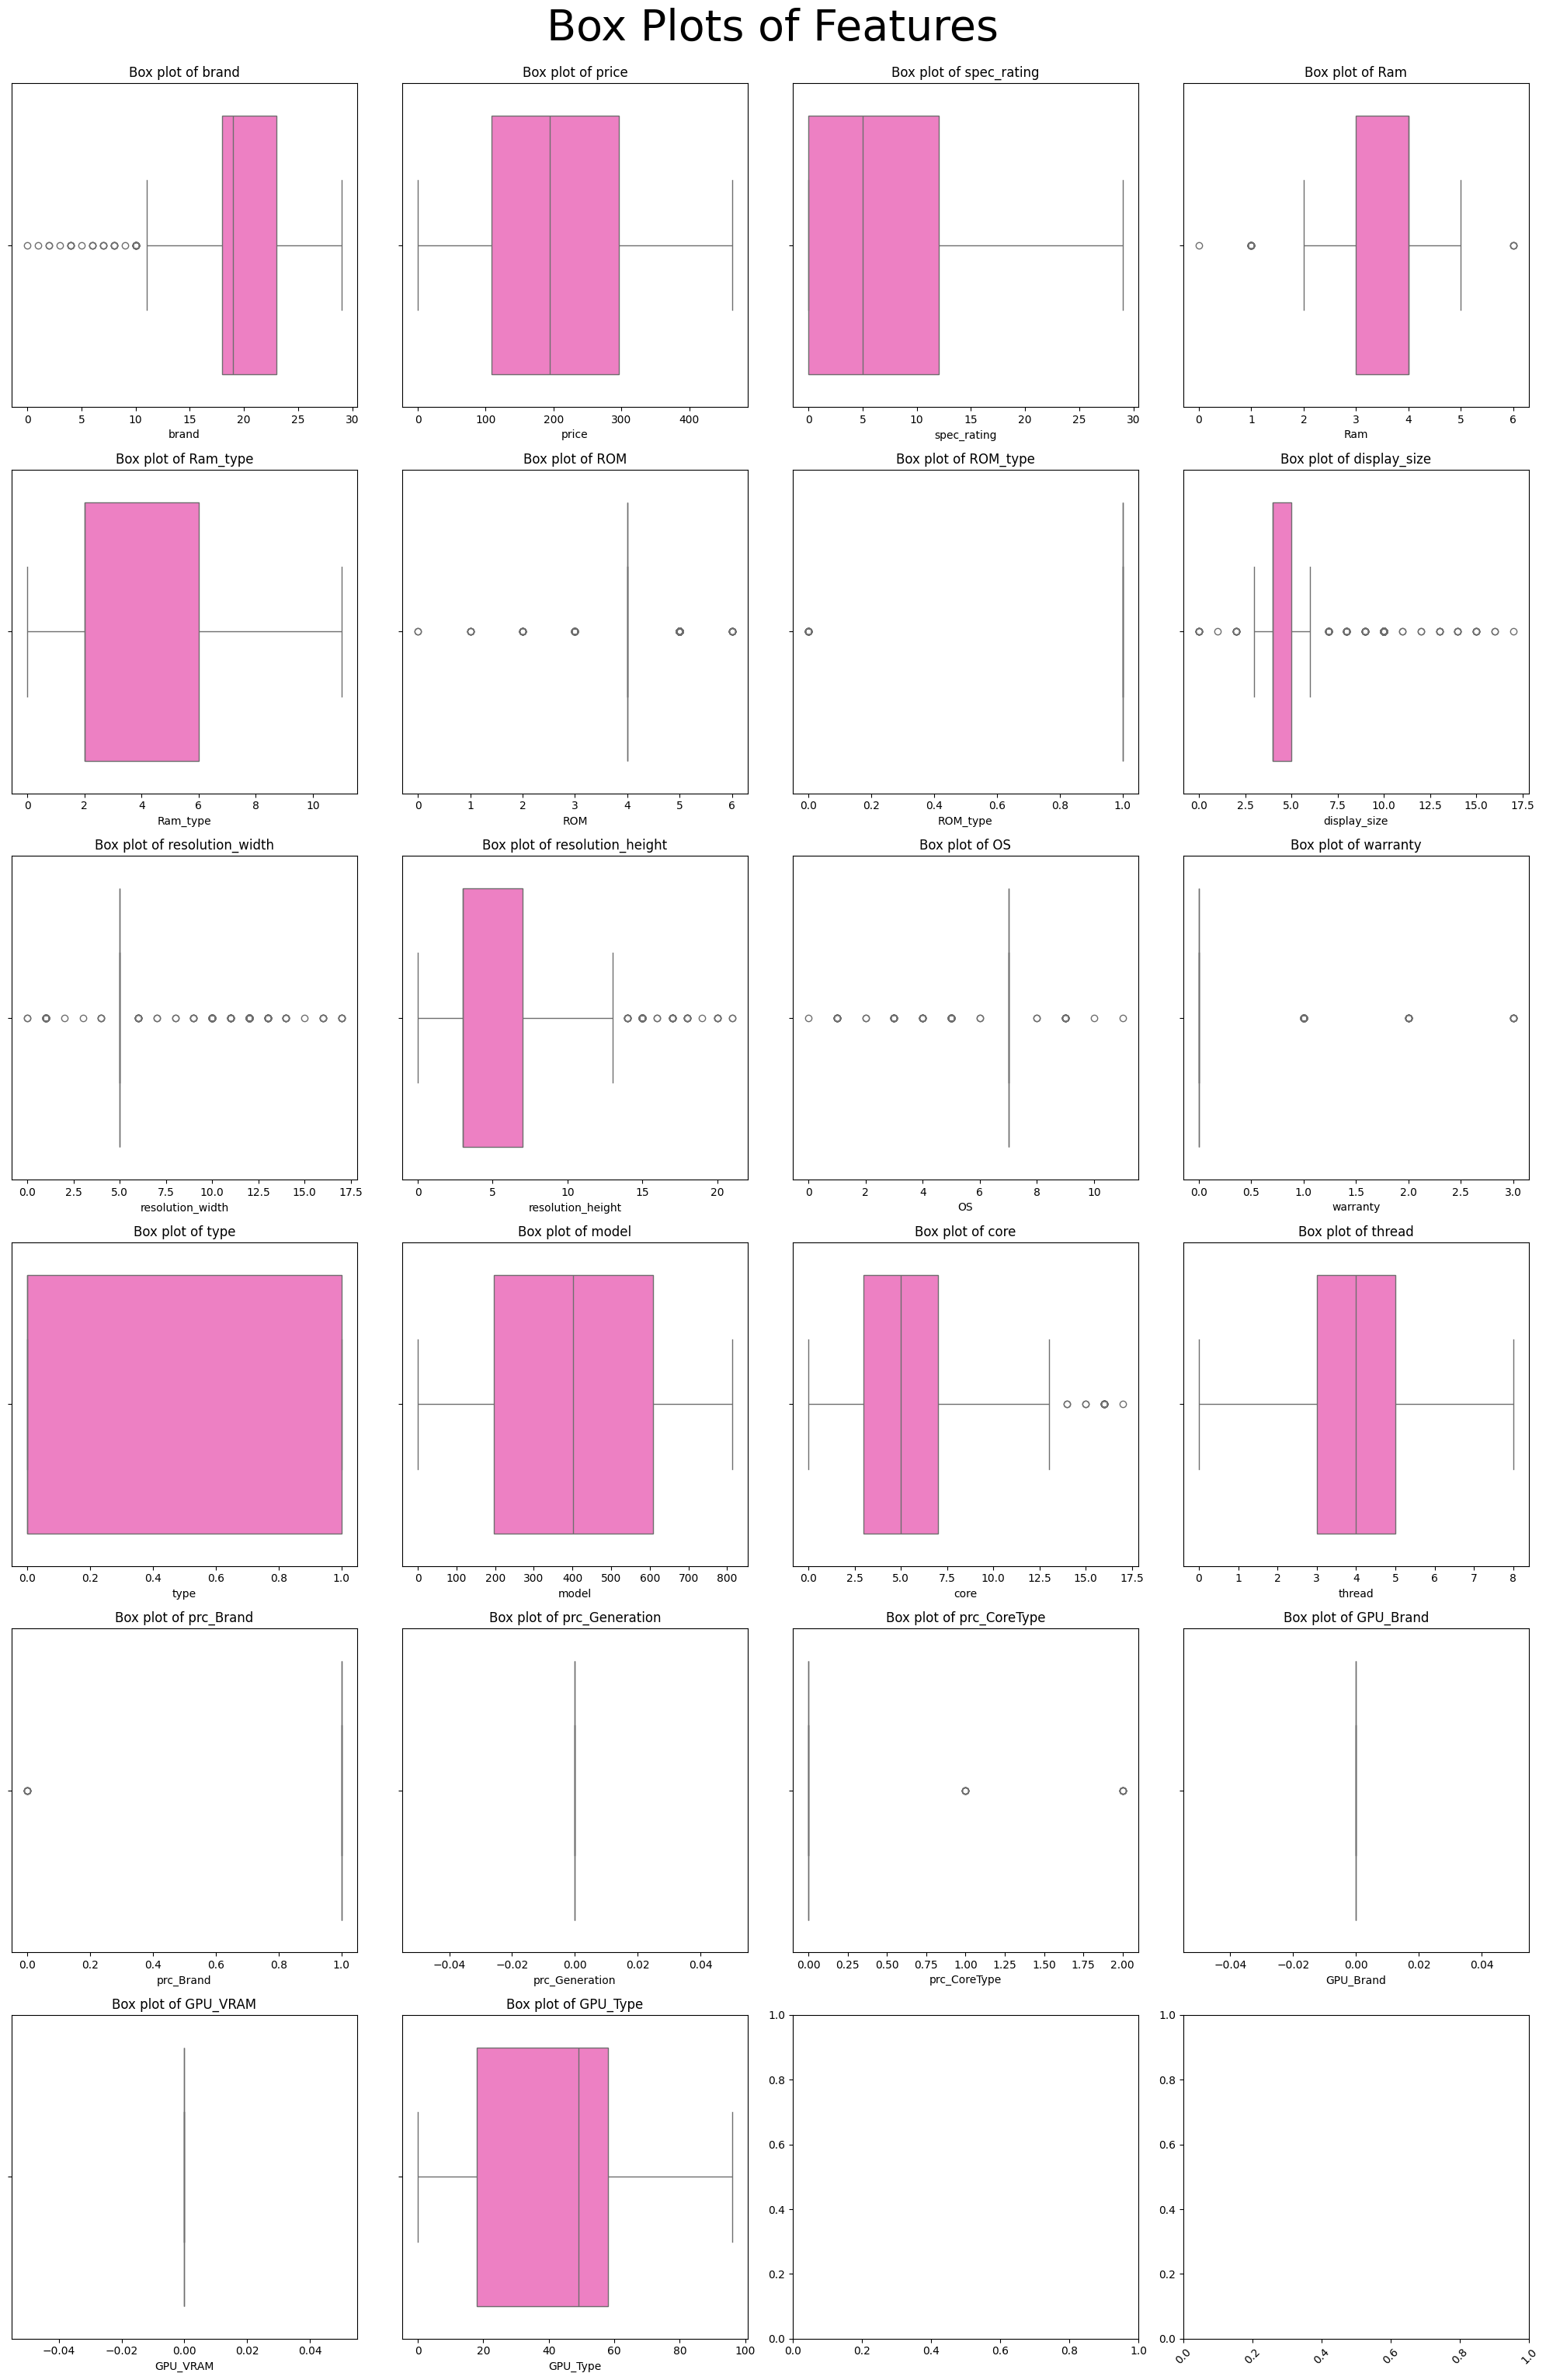

In [27]:
def print_box_plot(df):
    num_plots = len(df.columns)
    rows = int(np.ceil(num_plots/4))

    fig, axs = plt.subplots(rows,4, layout="constrained", figsize=(20, 5*rows))
    axs = axs.flatten()

    for i, c in enumerate(df.columns):
        sns.boxplot(x=df[c], ax=axs[i], color='#FF6EC7')
        axs[i].set_title(f'Box plot of {c}')

    # To ensure the subplots do not overlap
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.suptitle('Box Plots of Features', x=0.5, y=1.02, fontsize =40)

    plt.show()

print_box_plot(data)

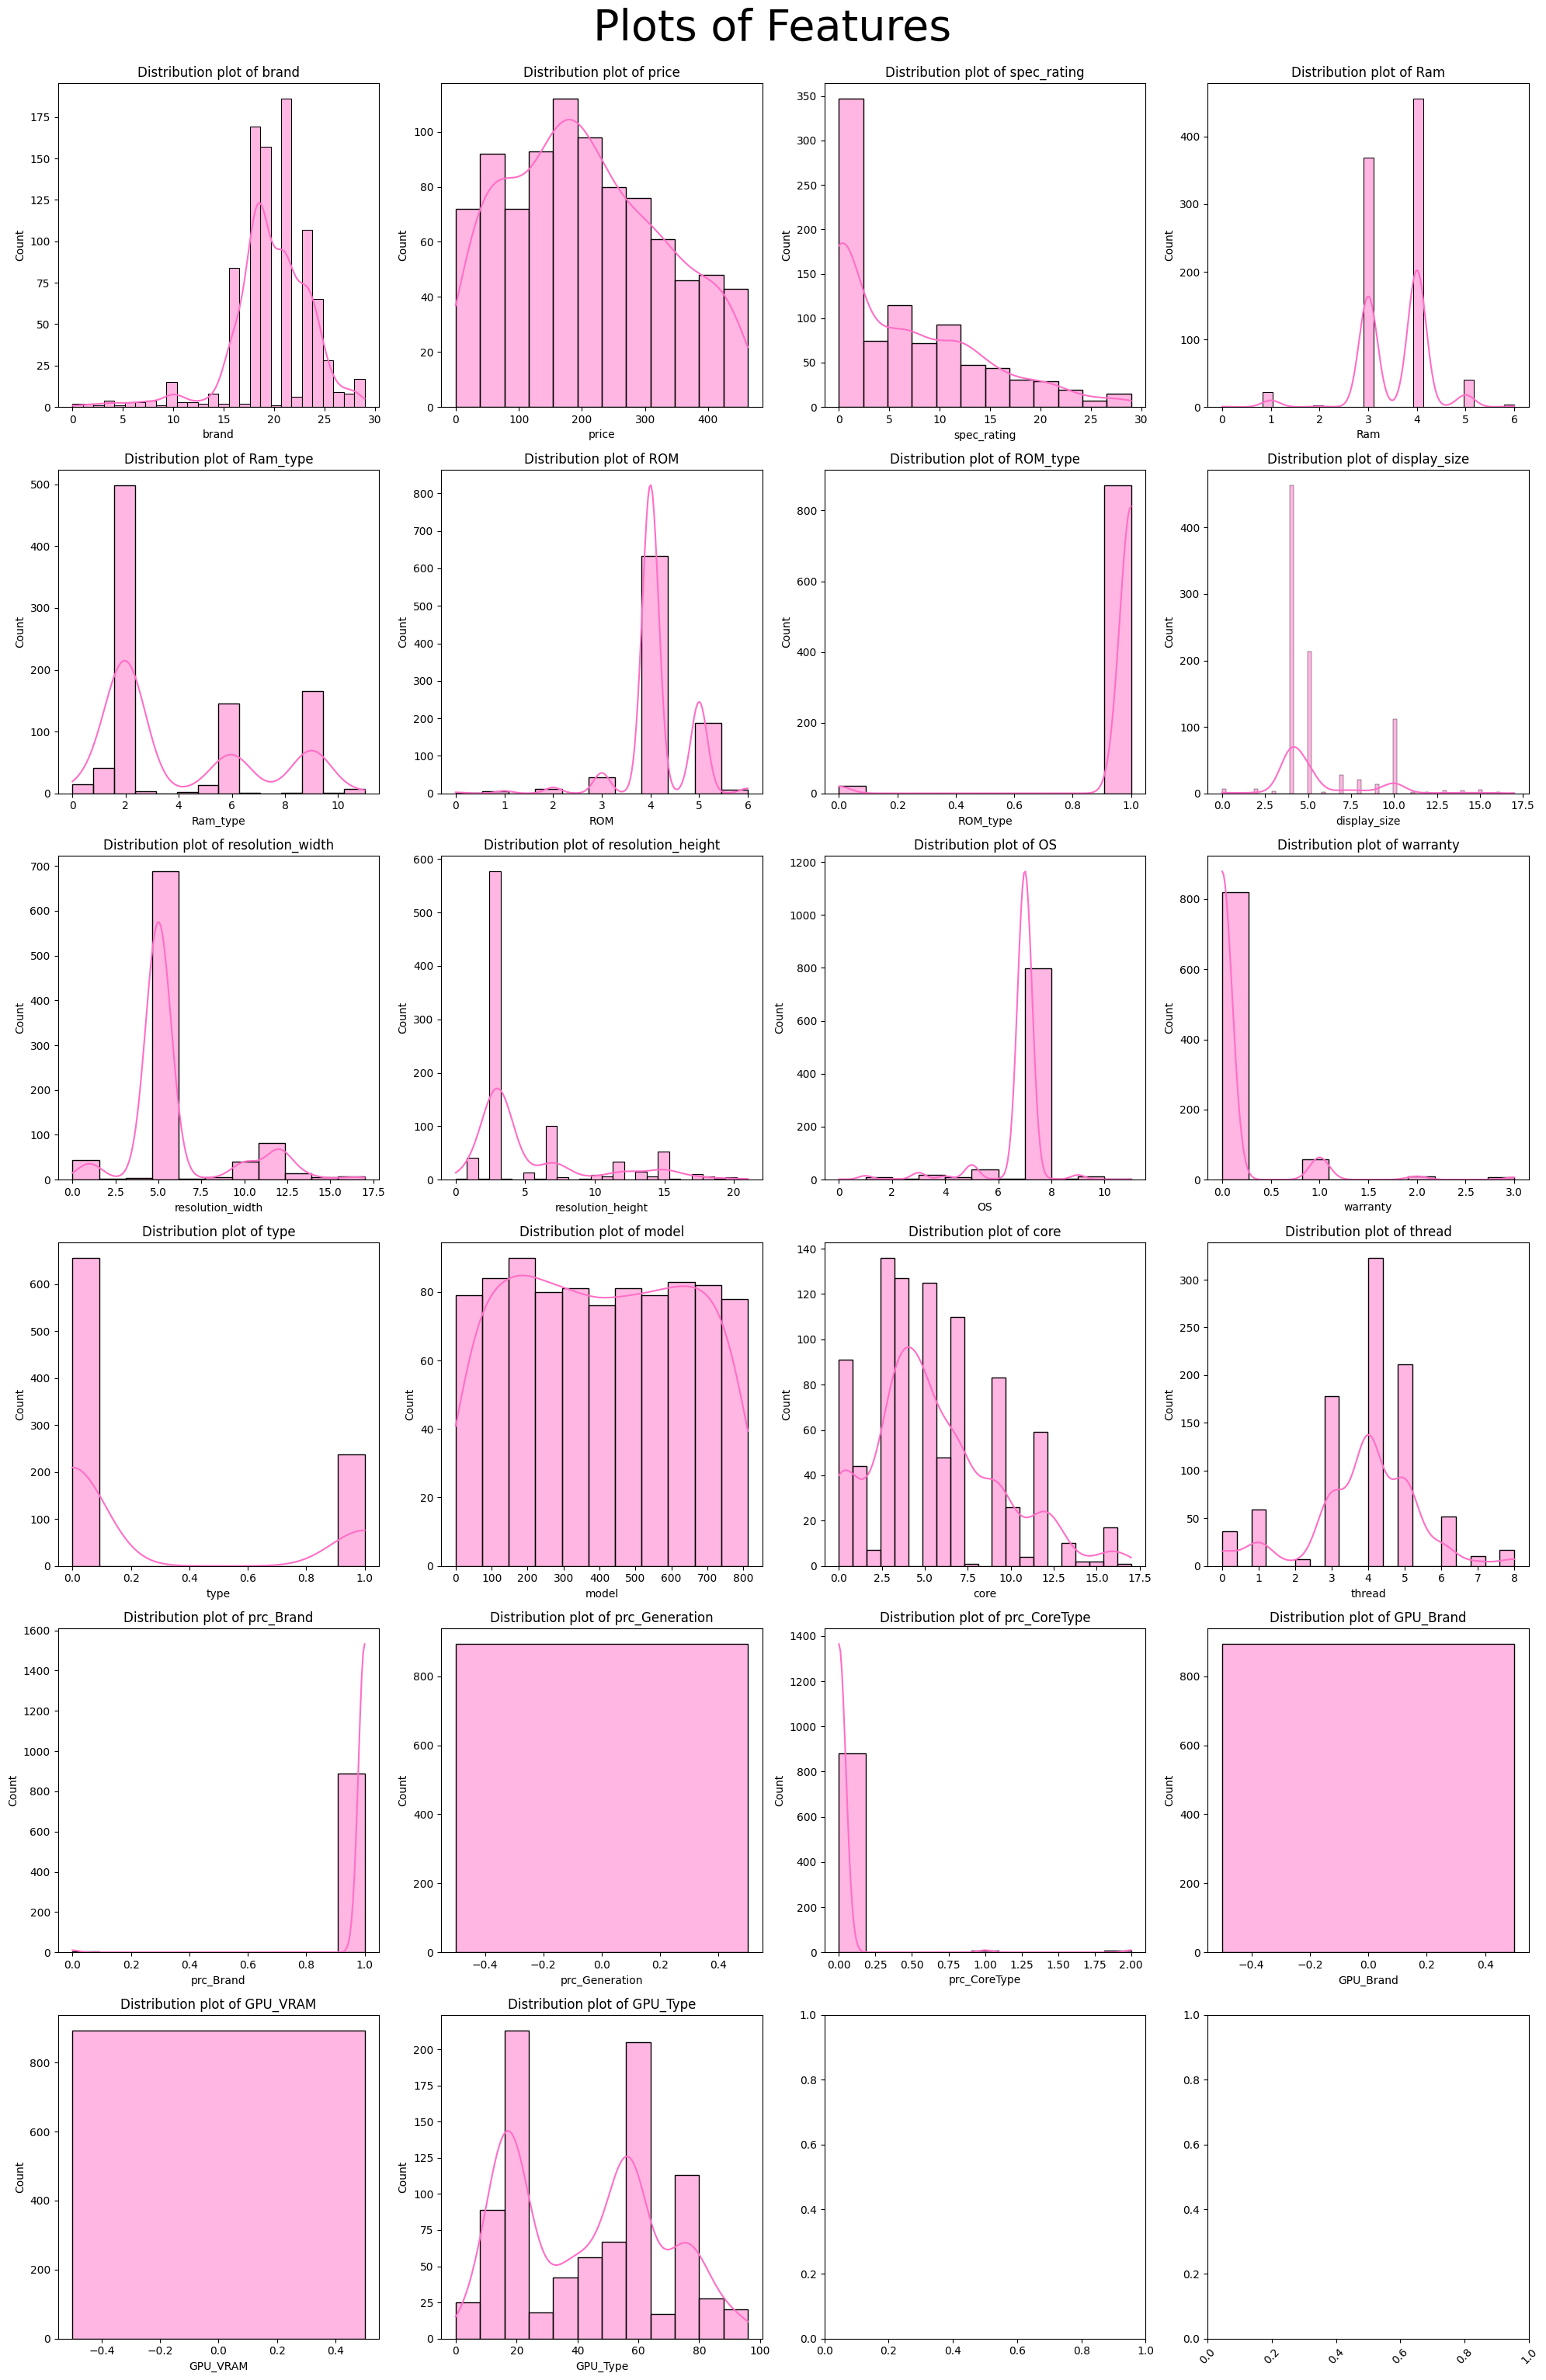

In [28]:
def print_histo(df):
    num_plots = len(df.columns)
    rows = int(np.ceil(num_plots/4))

    fig, axs = plt.subplots(rows,4, layout="constrained", figsize=(20, 5*rows))
    axs = axs.flatten()

    for i, c in enumerate(df.columns):
        sns.histplot(data[c], ax=axs[i], color='#FF6EC7', kde=True)
        axs[i].set_title(f'Distribution plot of {c}')

    # To ensure the subplots do not overlap
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.suptitle('Plots of Features', x=0.5, y=1.02, fontsize =40)

    plt.show()

print_histo(data)

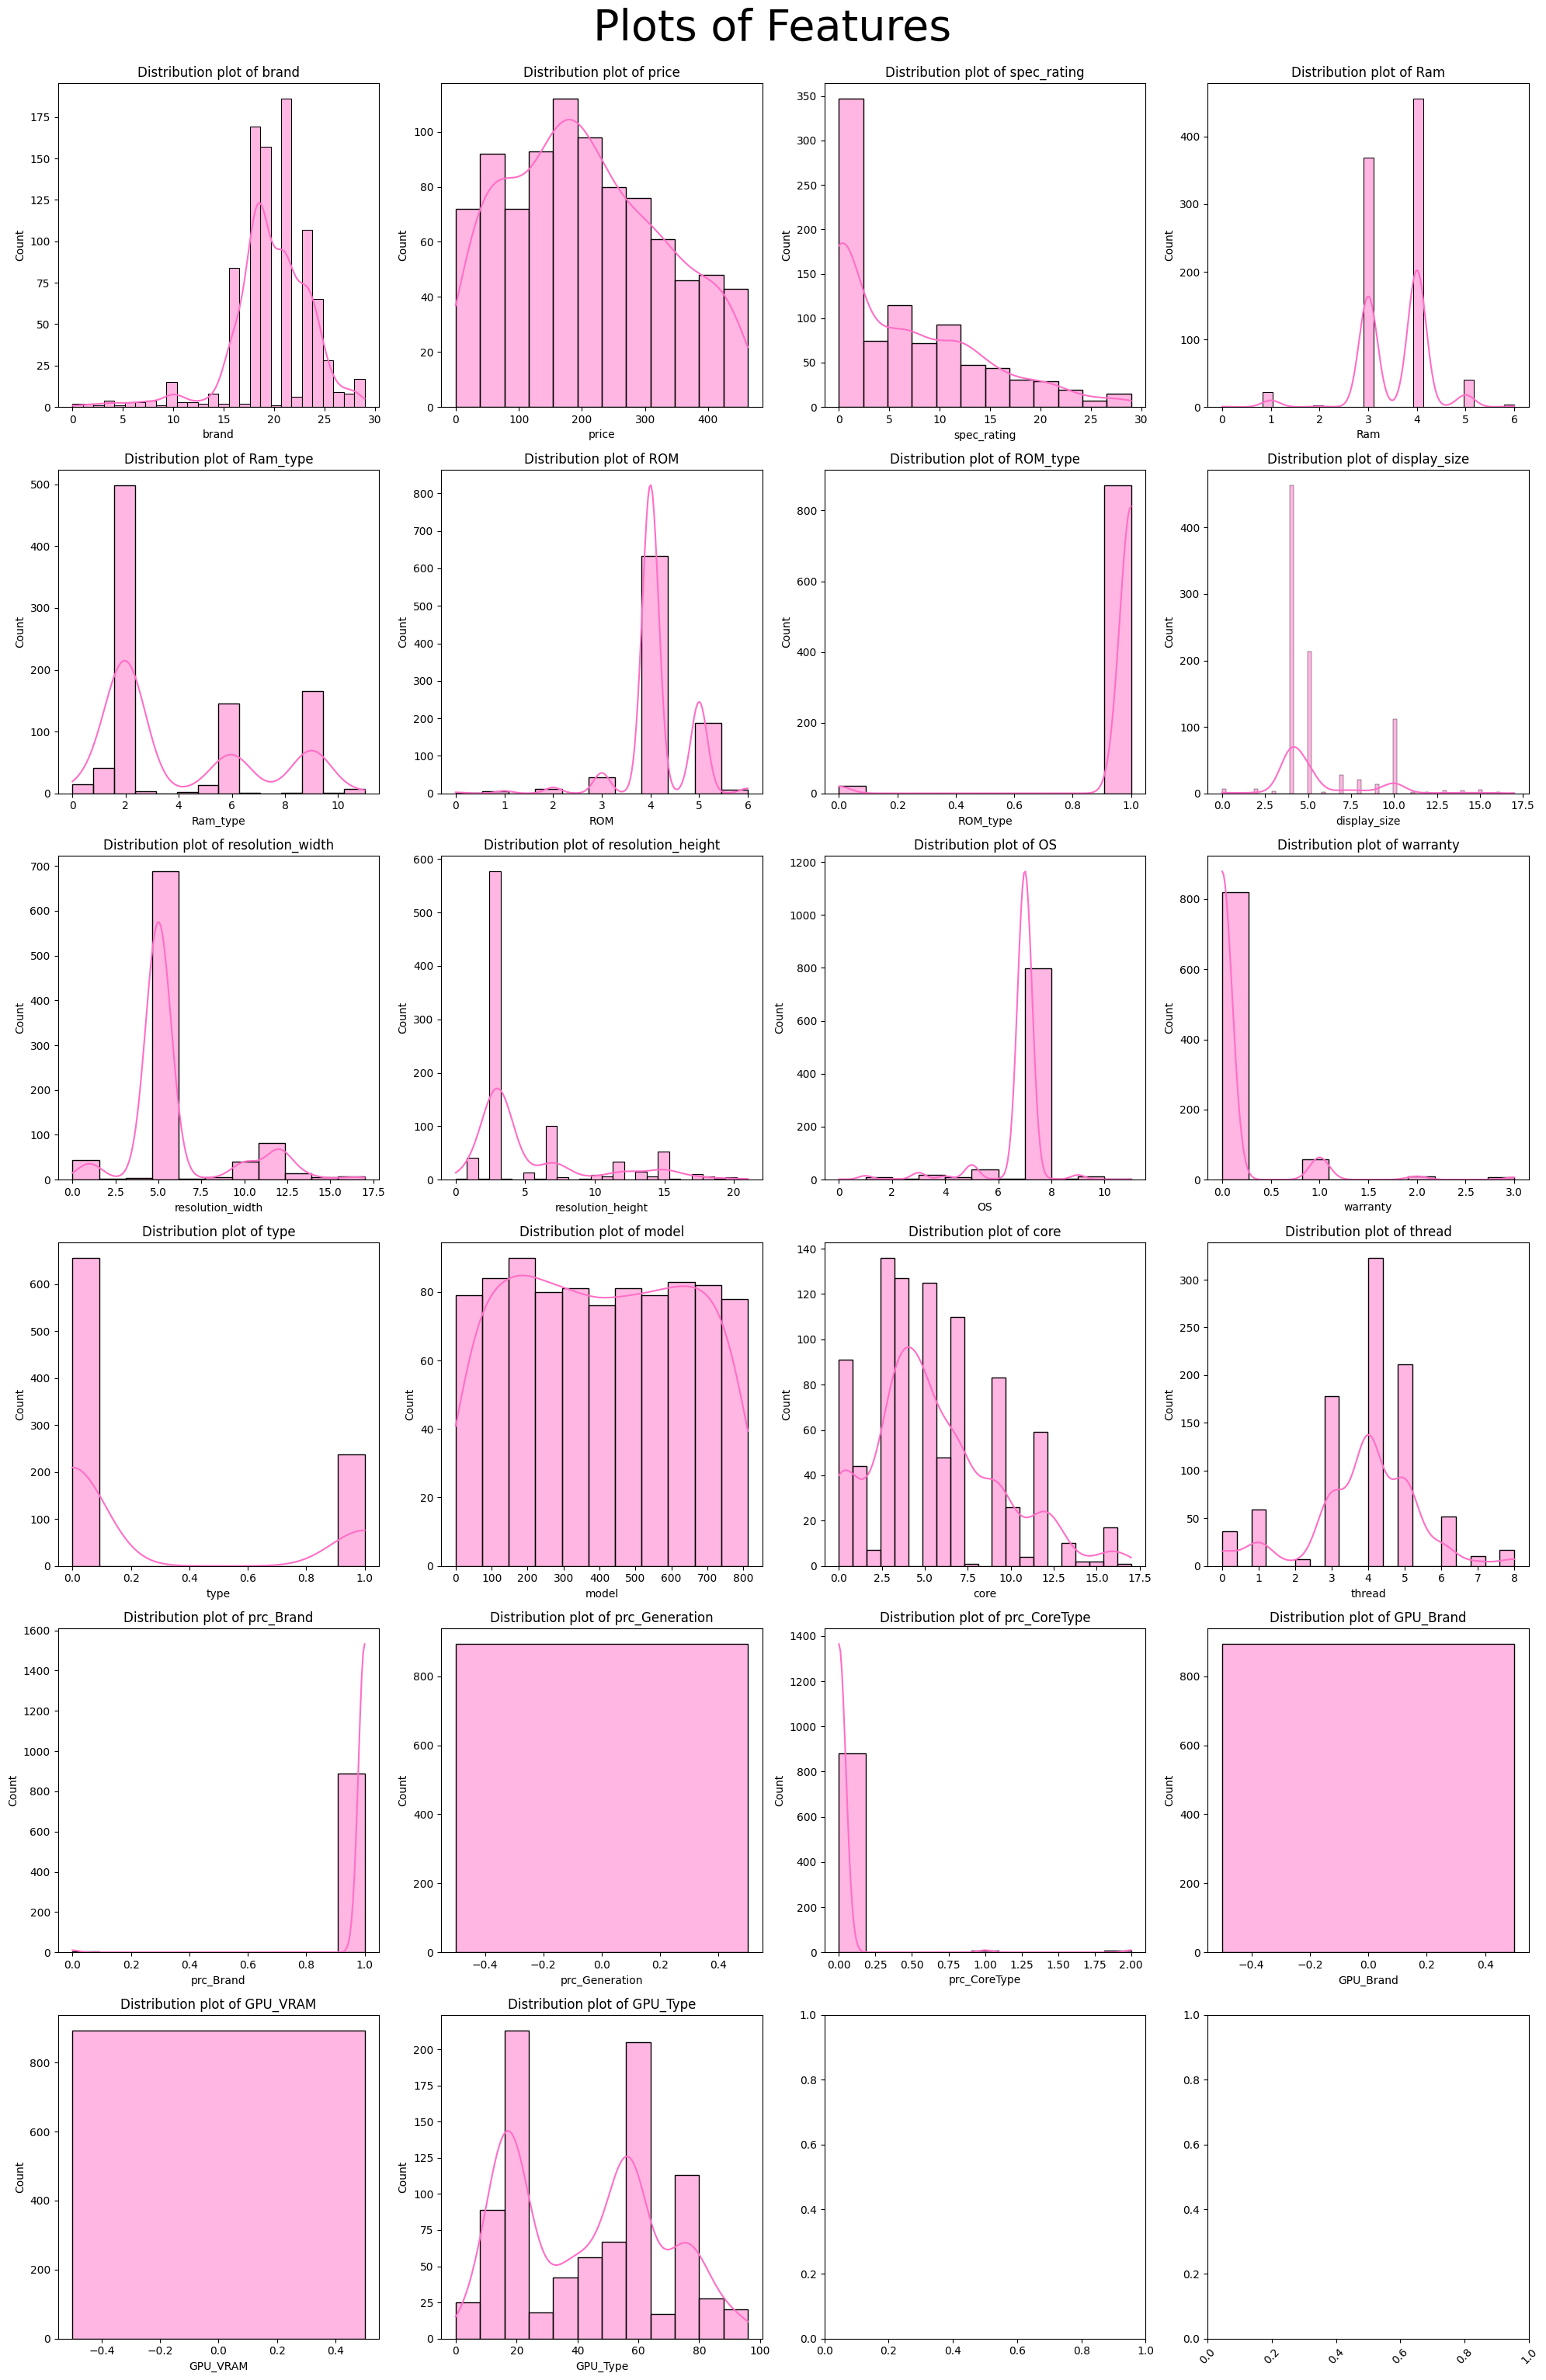

In [29]:
# Apply Quantile transformation

scaler_quantile = QuantileTransformer(output_distribution='normal')
scaled_quantile = scaler_quantile.fit_transform(data)
print_histo(data)

In [30]:
# Check Nulls
for c in data.columns:
  display(data[c].isnull().sum())

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

0

In [31]:
data.head()

,brand,price,spec_rating,Ram,Ram_type,ROM,ROM_type,display_size,resolution_width,resolution_height,...,type,model,core,thread,prc_Brand,prc_Generation,prc_CoreType,GPU_Brand,GPU_VRAM,GPU_Type
0,21,135,14.0,3,2,4,1,4.0,5,3,...,1,246,4,4,1,0,0,0,0,24
1,21,85,1.0,3,2,4,1,4.0,5,3,...,0,158,1,3,1,0,0,0,0,17
2,16,24,0.0,3,2,4,1,5.0,5,3,...,0,37,0,1,1,0,0,0,0,58
3,18,185,8.0,4,6,4,1,5.0,8,4,...,0,374,9,5,1,0,0,0,0,49
4,28,226,0.0,3,2,3,1,7.0,12,15,...,0,479,6,4,1,0,1,0,0,73


### Feature Selection

<Axes: >

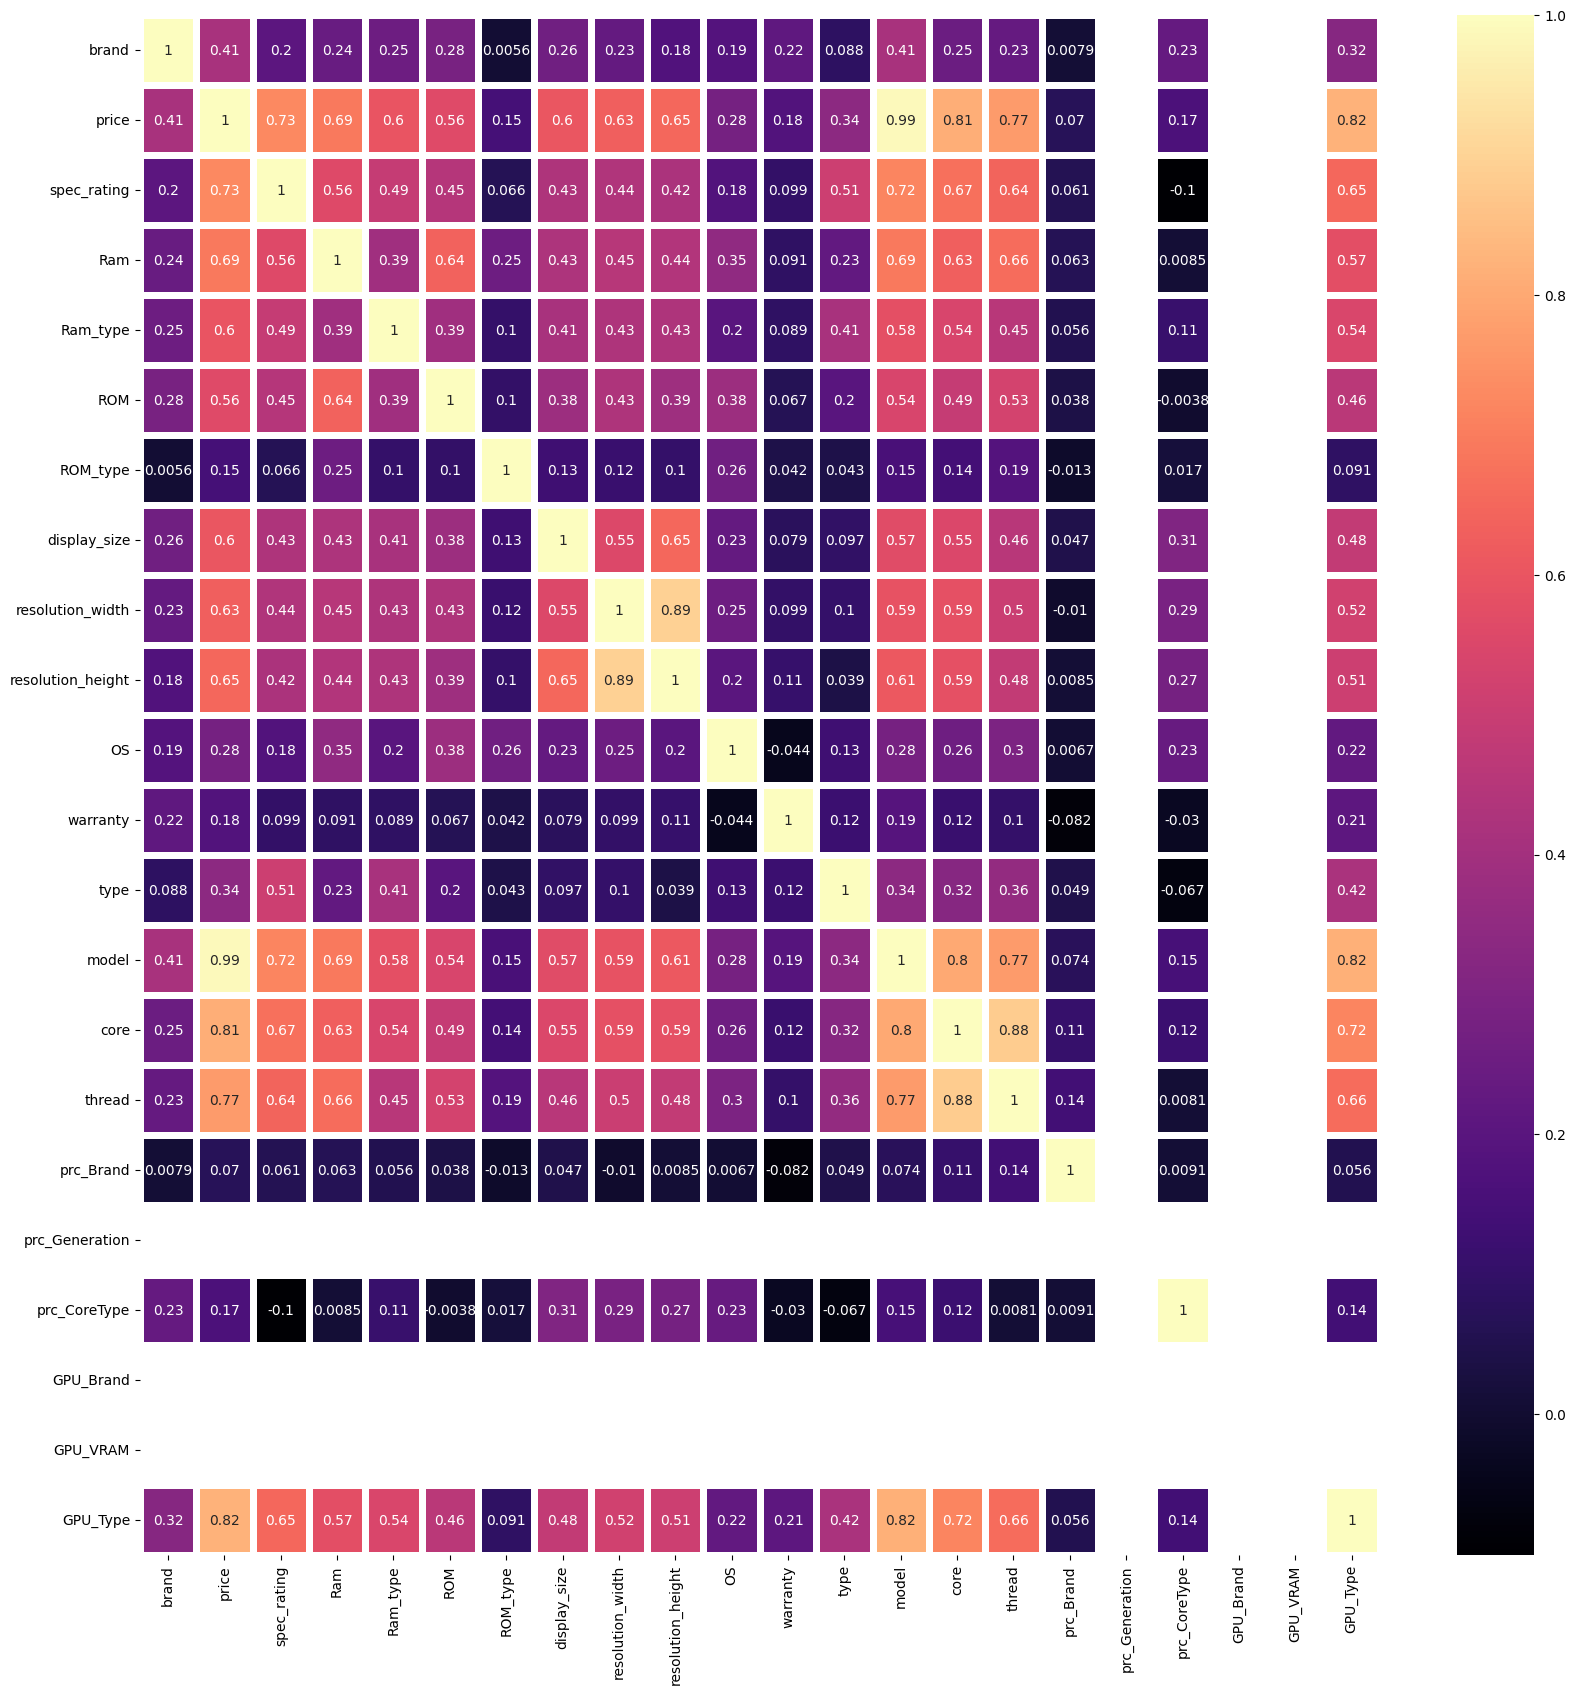

In [32]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), cmap='magma', annot=True, linewidths=5)

<Axes: >

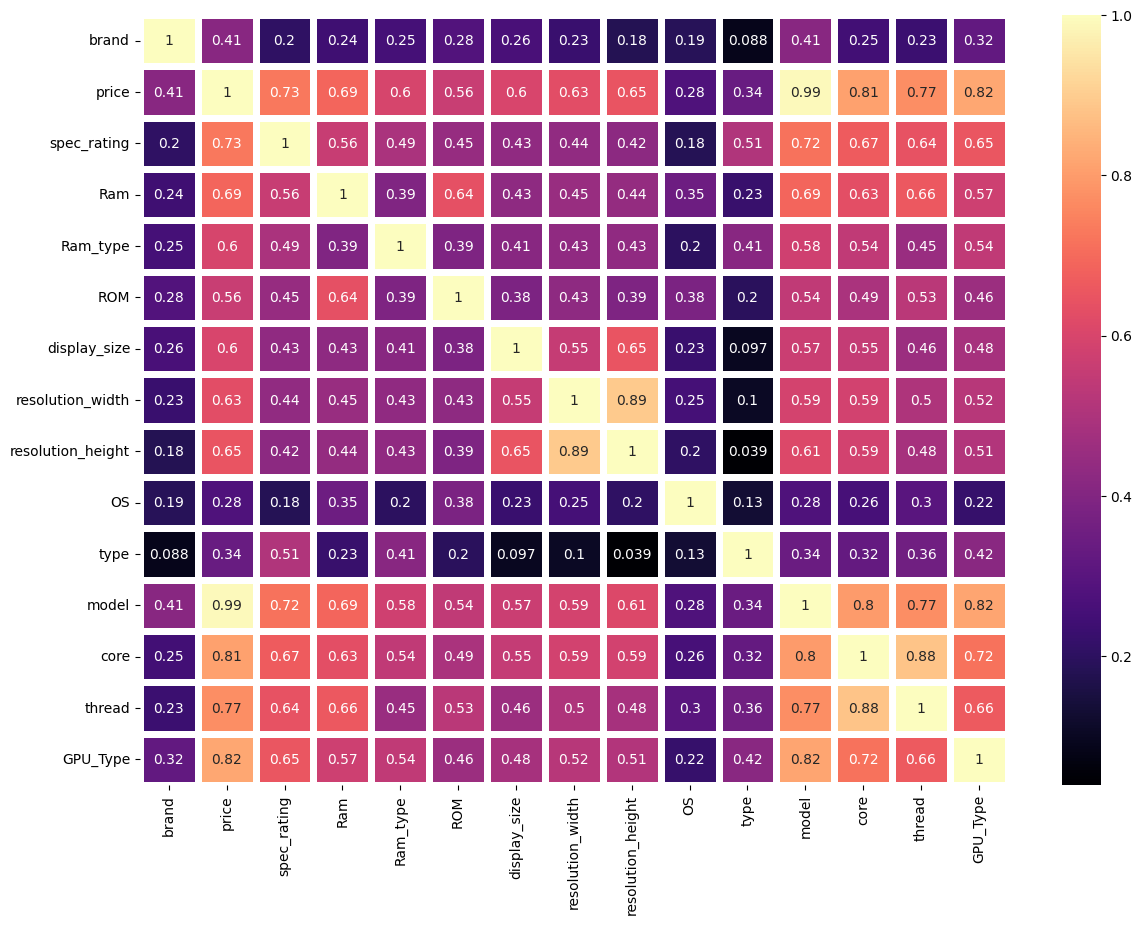

In [33]:
corr = data.corr()

# Select upper triangle of correlation matrix
m = (corr.mask(np.eye(len(corr), dtype=bool)).abs()>0.33).any()

data = data.loc[:, m]

plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), cmap='magma', annot=True, linewidths=5)

In [34]:
# Slected Features
data.head()

,brand,price,spec_rating,Ram,Ram_type,ROM,display_size,resolution_width,resolution_height,OS,type,model,core,thread,GPU_Type
0,21,135,14.0,3,2,4,4.0,5,3,7,1,246,4,4,24
1,21,85,1.0,3,2,4,4.0,5,3,7,0,158,1,3,17
2,16,24,0.0,3,2,4,5.0,5,3,7,0,37,0,1,58
3,18,185,8.0,4,6,4,5.0,8,4,7,0,374,9,5,49
4,28,226,0.0,3,2,3,7.0,12,15,9,0,479,6,4,73


### Training of Linear Regression, Random Forest, Decision Tree, SVC Models

In [35]:
target = data['price']
features = data.drop('price',axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

features.head()

,brand,spec_rating,Ram,Ram_type,ROM,display_size,resolution_width,resolution_height,OS,type,model,core,thread,GPU_Type
0,21,14.0,3,2,4,4.0,5,3,7,1,246,4,4,24
1,21,1.0,3,2,4,4.0,5,3,7,0,158,1,3,17
2,16,0.0,3,2,4,5.0,5,3,7,0,37,0,1,58
3,18,8.0,4,6,4,5.0,8,4,7,0,374,9,5,49
4,28,0.0,3,2,3,7.0,12,15,9,0,479,6,4,73


In [36]:
#linear regression
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)

predictions = linear_model.predict(X_train)
print("The accuracy of train is:",r2_score(y_train,predictions)*100)

predictions_test = linear_model.predict(X_test)
print("The accuracy of test is:",r2_score(y_test,predictions_test)*100)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, predictions_test))
print("The RMSE of test is:", rmse)

The accuracy of train is: 98.8196353048385
The accuracy of test is: 98.66869197448442
The RMSE of test is: 13.661253753540594


In [37]:
# tuning for linear regression 

# Define the model
model = Ridge()

# Define the grid of hyperparameters 'param_grid'
param_grid = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}

# Use gridsearch to test all values for 'alpha'
model_gscv = GridSearchCV(model, param_grid, cv=5)

# Fit model to data
model_gscv.fit(X_train,y_train)

# Find the best value for 'alpha'
print("Best alpha: ", model_gscv.best_params_)

pred_tune = model_gscv.predict(X_train)
print("The accuracy of train is:",r2_score(y_train,pred_tune)*100)

pred_tune = linear_model.predict(X_test)
print("The accuracy of test is:",r2_score(y_test,pred_tune)*100)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, pred_tune))
print("The RMSE of test is:", rmse)


Best alpha:  {'alpha': 20}
The accuracy of train is: 98.81877003102711
The accuracy of test is: 98.66869197448442
The RMSE of test is: 13.661253753540594


In [38]:
#Training random forest
rfc = RandomForestRegressor(random_state=1)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print("Random Forest Classifier Accuracy:", r2_score(y_test, y_pred_rfc)*100)

Random Forest Classifier Accuracy: 98.8017642338346


In [39]:
#Train the Decision Tree model
dtc = DecisionTreeRegressor(random_state=120)
dtc.fit(X_train,y_train)
y_pred_dtc = dtc.predict(X_test)
print("Decision Tree Classifier Accuracy:", r2_score(y_test, y_pred_dtc)*100)

Decision Tree Classifier Accuracy: 97.66799130001777


In [40]:
#Train SVC
svc_model = SVR()
svc_model.fit(X_train, y_train)
predictions = svc_model.predict(X_test)
print("SVC Classifier Accuracy:", r2_score(y_test, predictions)*100)

SVC Classifier Accuracy: 88.35994675963987
